In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import random
import shap
shap.initjs()

/Users/akosimolay/Studies/ETH Zurich/2nd semester/Machine Learning for Helath Care/project 2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
TRAIN_BATCH_SIZE = 16
VAL_TEST_BATCH_SIZE = 32
LEARNING_RATE = .001

random.seed(42)
np.random.seed(42)

numerical_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'FastingBS']
all_vars = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

In [47]:
# Loading the data
scaler = MinMaxScaler()

df_train_val = pd.read_parquet('data/train_val.parquet')
df_test = pd.read_parquet('data/test.parquet')

X_train_val = df_train_val.drop('HeartDisease', axis=1)
X_train_val[numerical_vars] = scaler.fit_transform(X_train_val[numerical_vars])
X_train_val = X_train_val.to_numpy()
X_test = df_test.drop('HeartDisease', axis=1)
X_test[numerical_vars] = scaler.transform(X_test[numerical_vars])
X_test = X_test.to_numpy()

y_train_val = df_train_val['HeartDisease'].to_numpy()
y_test = df_test['HeartDisease'].to_numpy()

# Transforming the data to tensors
X_train_val = torch.from_numpy(X_train_val).float()
y_train_val = torch.from_numpy(y_train_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Splitting train_val into train and val 
##### LATER MAYBE KFOLD???
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.2, random_state=42, shuffle=True)

# Reshaping the outcomes to column vectors
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
#y_train_val = y_train_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Creating datasets from the tensors
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
#train_val_data = TensorDataset(X_train_val, y_train_val)
test_data = TensorDataset(X_test, y_test)

# Creating data loaders
train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=VAL_TEST_BATCH_SIZE, shuffle=False)
#train_val_dataloader = DataLoader(train_val_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=VAL_TEST_BATCH_SIZE, shuffle=False)

In [48]:
list(df_test.columns)

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

In [49]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * TRAIN_BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def evaluate_model(dataloader, model, loss_fn, is_test=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = 0
    correct = 0
    preds = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            
            loss += loss_fn(pred, y).item()
            pred = pred.sigmoid().round()
            correct += (pred == y).type(torch.float).sum().item()
            preds.append(pred.cpu())
            labels.append(y.cpu())
            
    preds = torch.cat(preds)              
    labels = torch.cat(labels)      
    loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):.2f}%, \n Avg loss: {loss:.4f}, \n f1 score: {f1_score(labels, preds):.4f} \n Balanced accuracy: {balanced_accuracy_score(labels, preds):.4f} \n")
    
    if not is_test:
        return loss


In [50]:
# Small neural network for each feature
class FeatureNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        return self.net(x)

# NAM model
class NAM(nn.Module):
    def __init__(self, num_features, hidden_dim=32):
        super().__init__()
        self.feature_nets = nn.ModuleList([
            FeatureNet(input_dim=1, hidden_dim=hidden_dim)
            for _ in range(num_features)
        ])

    def forward(self, x):
        # x: (batch_size, num_features)
        outputs = [net(x[:, i:i+1]) for i, net in enumerate(self.feature_nets)]
        out = torch.stack(outputs, dim=1).sum(dim=1)  # sum across features
        return out

In [51]:
# Small neural network for each feature
class FeatureNet(nn.Module):
    def __init__(self, input_dim=1, hidden_num=1, hidden_dim=32):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        
        for _ in range(hidden_num - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, input_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# NAM model
class NAM(nn.Module):
    def __init__(self, num_features, hidden_num=1, hidden_dim=32):
        super().__init__()
        self.feature_nets = nn.ModuleList([
            FeatureNet(input_dim=1, hidden_num=hidden_num, hidden_dim=hidden_dim)
            for _ in range(num_features)
        ])

    def forward(self, x):
        # x: (batch_size, num_features)
        outputs = [net(x[:, i:i+1]) for i, net in enumerate(self.feature_nets)]
        out = torch.stack(outputs, dim=1).sum(dim=1)  # sum across features
        return out

In [52]:
hidden_nums = [1, 2, 3, 4]
hidden_dims = [16, 32, 64, 128]
num_epochs = 15

scores = pd.DataFrame(columns=["hidden_layers", "hidden_units", "epochs", "loss"])
for hidden_num in hidden_nums:
    for hidden_dim in hidden_dims:
        print(f"MODEL: hidden_num: {hidden_num}, hidden_dim: {hidden_dim}\n\n")
        
        model = NAM(11, hidden_num=hidden_num, hidden_dim=hidden_dim)
        loss_fn = BCEWithLogitsLoss()
        optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
        
        losses = []
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}\n-------------------------------")
            train_one_epoch(train_dataloader, model, loss_fn, optimizer)
            loss = evaluate_model(val_dataloader, model, loss_fn)
            losses.append(loss)
        
        for i, loss in enumerate(losses):
            scores.loc[len(scores)] = [int(hidden_num), int(hidden_dim), int(i+1), loss]

print("Done!")

MODEL: hidden_num: 1, hidden_dim: 16


Epoch 1
-------------------------------
loss: 0.594676  [   16/  587]
loss: 0.526625  [  176/  587]
loss: 0.654764  [  336/  587]
loss: 0.550052  [  496/  587]
Test Error: 
 Accuracy: 83.67%, 
 Avg loss: 0.5247, 
 f1 score: 0.8554 
 Balanced accuracy: 0.8333 

Epoch 2
-------------------------------
loss: 0.513613  [   16/  587]
loss: 0.623558  [  176/  587]
loss: 0.513602  [  336/  587]
loss: 0.528356  [  496/  587]
Test Error: 
 Accuracy: 83.67%, 
 Avg loss: 0.4825, 
 f1 score: 0.8605 
 Balanced accuracy: 0.8319 

Epoch 3
-------------------------------
loss: 0.410012  [   16/  587]
loss: 0.327064  [  176/  587]
loss: 0.601504  [  336/  587]
loss: 0.470085  [  496/  587]
Test Error: 
 Accuracy: 83.67%, 
 Avg loss: 0.4394, 
 f1 score: 0.8519 
 Balanced accuracy: 0.8342 

Epoch 4
-------------------------------
loss: 0.380052  [   16/  587]
loss: 0.377359  [  176/  587]
loss: 0.458178  [  336/  587]
loss: 0.512600  [  496/  587]
Test Error: 
 Accu

In [53]:
min_loss = scores.loc[:, 'loss'].min()
best_scores = scores[scores["loss"] == min_loss].reset_index()
best_hidden_num = int(best_scores.loc[0, "hidden_layers"])
best_hidden_dim = int(best_scores.loc[0, "hidden_units"])
best_num_epochs = int(best_scores.loc[0, "epochs"])
best_scores


,index,hidden_layers,hidden_units,epochs,loss
0,104,2.0,64.0,15.0,0.30481


Epoch 1
-------------------------------
loss: 0.703366  [   16/  587]
loss: 0.778291  [  176/  587]
loss: 0.591381  [  336/  587]
loss: 0.544077  [  496/  587]
Test Error: 
 Accuracy: 81.63%, 
 Avg loss: 0.5322, 
 f1 score: 0.8421 
 Balanced accuracy: 0.8117 

Epoch 2
-------------------------------
loss: 0.500059  [   16/  587]
loss: 0.638147  [  176/  587]
loss: 0.433022  [  336/  587]
loss: 0.438819  [  496/  587]
Test Error: 
 Accuracy: 82.99%, 
 Avg loss: 0.4400, 
 f1 score: 0.8521 
 Balanced accuracy: 0.8258 

Epoch 3
-------------------------------
loss: 0.512318  [   16/  587]
loss: 0.362294  [  176/  587]
loss: 0.473357  [  336/  587]
loss: 0.269266  [  496/  587]
Test Error: 
 Accuracy: 84.35%, 
 Avg loss: 0.3758, 
 f1 score: 0.8535 
 Balanced accuracy: 0.8422 

Epoch 4
-------------------------------
loss: 0.332989  [   16/  587]
loss: 0.260697  [  176/  587]
loss: 0.391401  [  336/  587]
loss: 0.190633  [  496/  587]
Test Error: 
 Accuracy: 85.71%, 
 Avg loss: 0.3517, 
 f1 

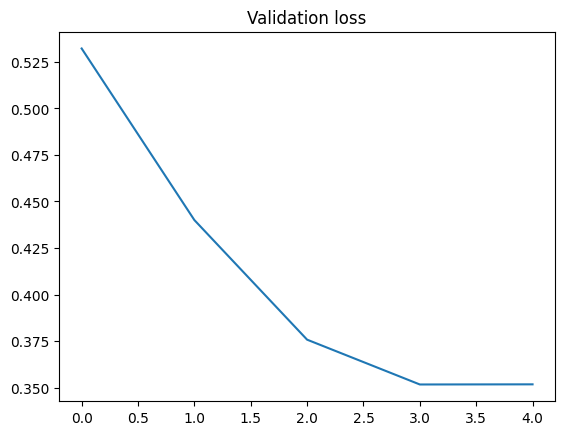

In [54]:
model = NAM(11, hidden_num=2, hidden_dim=32)
loss_fn = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

losses = []
for epoch in range(5):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    loss = evaluate_model(val_dataloader, model, loss_fn)
    losses.append(loss)

print("Done!")

plt.plot(losses)
plt.title("Validation loss")
plt.show()

In [55]:
model.eval()
evaluate_model(test_dataloader, model, loss_fn, is_test=True)

Test Error: 
 Accuracy: 82.61%, 
 Avg loss: 0.4132, 
 f1 score: 0.8621 
 Balanced accuracy: 0.8059 



### 32 hidden dim 5 epochs
Test Error: 
 Accuracy: 83.15%, 
 Avg loss: 0.4099, 
 f1 score: 0.8584 
 Balanced accuracy: 0.8259 

 ### 64 hidden dim 5 epochs
Test Error: 
 Accuracy: 84.24%, 
 Avg loss: 0.3926, 
 f1 score: 0.8711 
 Balanced accuracy: 0.8306 

# Visualizing the model

In [65]:
def visualize_feature(model, feature_index, feature_name, ax, num_categories=None, x_range=(0, 1), num_points=100):
    net = model.feature_nets[feature_index]
    with torch.no_grad():
        if num_categories is None:
            numerical_index = numerical_vars.index(feature_name)
            data_min = scaler.data_min_[numerical_index]
            data_max = scaler.data_max_[numerical_index]
            
            x_vals = torch.linspace(*x_range, steps=num_points).unsqueeze(1)
            y_vals = net(x_vals).squeeze()
            x_vals_original = x_vals * (data_max - data_min) + data_min
            ax.plot(x_vals_original.numpy(), y_vals.numpy())
        
        else:
            x_vals = torch.arange(num_categories).float().view(-1, 1)
            y_vals = net(x_vals).squeeze().numpy()
            ax.bar(x_vals.squeeze().numpy(), y_vals)
            #ax.set_xticks(num_categories)
        
        ax.set_title(feature_name)
        ax.set_xlabel(feature_name)
        ax.set_ylabel(f"{feature_name} contribution")

def visualize_numerical_feature(model, feature_index, ax, feature_name=None, x_range=(0, 1), num_points=100):
    if feature_name is None:
        feature_name = f"Feature {feature_index}"
        
    x_vals = torch.linspace(*x_range, steps=num_points).unsqueeze(1)
    with torch.no_grad():
        y_vals = model.feature_nets[feature_index](x_vals).squeeze()
    ax.plot(x_vals.numpy(), y_vals.numpy())
    ax.title(feature_name)
    ax.xlabel(feature_name)
    ax.ylabel(f"{feature_name} contribution")
    plt.show()
    

def visualize_ordinal_feature(model, feature_index, num_categories, ax):
    values = torch.arange(num_categories).float().view(-1, 1)
    net = model.feature_nets[feature_index]

    with torch.no_grad():
        contributions = net(values).squeeze().numpy()

    ax.bar(range(num_categories), contributions)
    ax.xlabel("Category Index")
    ax.ylabel("Contribution to logit")
    ax.title(f"Ordinal Feature {feature_index}")
    plt.show()

In [66]:
scaler.data_min_
numerical_vars.index("Age")

0

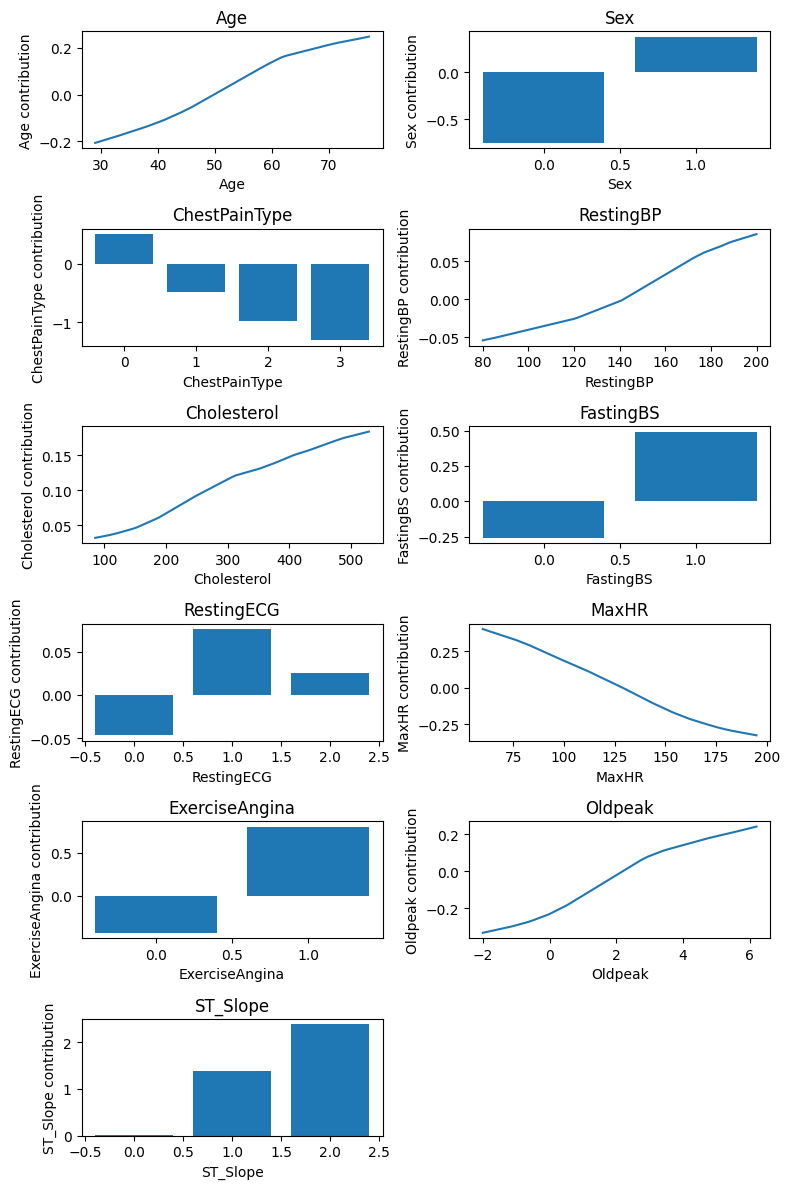

In [67]:
fig, axs = plt.subplots(6, 2, figsize=(8, 12))
for k, var in enumerate(all_vars):
    i = int(k / 2)
    j = int(k - i*2) % 2
    num_categories = None
    if var in categorical_vars:
        num_categories = len(df_test[var].unique())
    visualize_feature(model, k, var, axs[i, j], num_categories=num_categories)

axs[5, 1].set_visible(False)
plt.tight_layout()
plt.show()